In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0


In [2]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../../Code\\process.py'>

In [3]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader_training.json")
validation = process.Processor("data_loader_validation.json")
output_names = ["g1","d1","o1","f1","f2","o2","d2","g2","-2"]

Creating transform: random_video_loader
Adding folder '.\..\..\Data\Processed\BallTracking\'
'.\..\..\Data\Processed\BallTracking\balltracking_0.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_1.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_2.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_3.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_4.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_5.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_6.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_7.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_8.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_9.avi': 4073 frames found.
Loaded 75258 frames in random loader.
Distribution:
{'balltracking_.avi': 94073}
Creating transform: randomize_frame
Creating tr

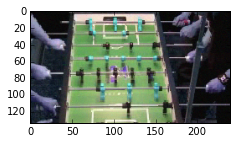

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


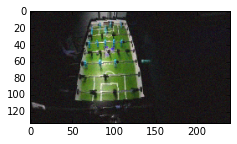

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


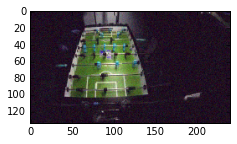

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


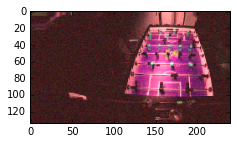

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


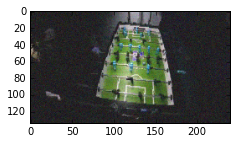

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


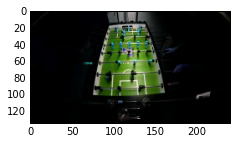

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


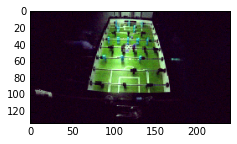

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


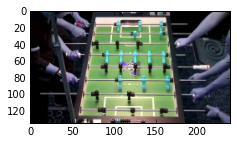

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


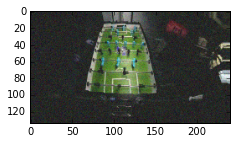

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


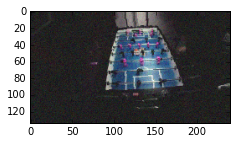

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


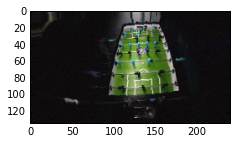

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


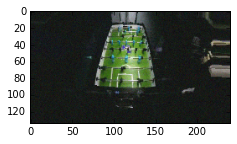

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


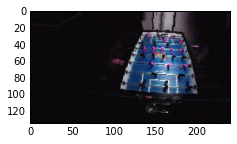

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


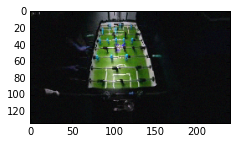

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


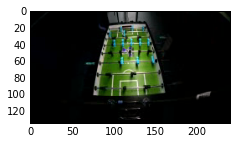

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


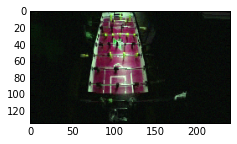

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


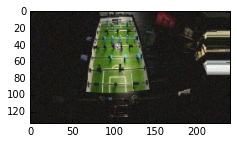

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


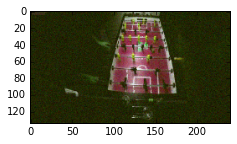

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


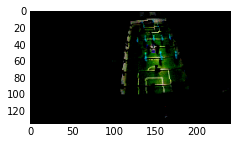

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


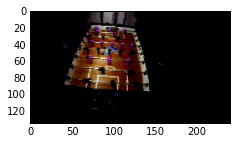

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(20):
    data = training.get_next_frame()
    frame = data["frame"]
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frame)
    plt.show()
    pp.pprint( np.transpose( np.array(data["values"] ) ))

In [5]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame = data["frame"]
            output = np.array(data["values"])

            while frame is not None:
                yield (frame, output)
                data = training.get_next_frame()
                if data is not None:
                    frame = data["frame"]
                    output = np.array(data["values"])
                else:
                    frame = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

                
             
# Generators for training the position
@threadsafe_generator
def ValidationBatchGen(batch_size, validation):
    gen = TrainGen(validation)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
    
    
        
    


In [6]:
# Utilities for plotting the result and training
def plot_validate(generator, model, count, name, output_names):   
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    
    f, axes = plt.subplots(outputs_true.shape[1], figsize=(12, 12), sharex=True, sharey=True)
    
    for i in range(outputs_true.shape[1]):
        true, predicted = zip(*sorted(zip(outputs_true[0:count,i], outputs_predicted[0:count,i])))
        axes[i].plot(range(count),true, label="True position" )
        axes[i].plot(range(count),predicted, label="Predicted position" )
        axes[i].grid(False)
        axes[i].set_ylabel(output_names[i])
        if i == 0:
            axes[i].legend()
            axes[i].set_title(name)
            
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    
    plt.show()

    
    



In [7]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(image_height, image_width, image_channels,),
              name="Input")
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling2D( pool_size=(1, 2),
                  name = "max_pooling2d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1


#x = Flatten()(x)
#x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)
x = Flatten()(x)


x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

'Input shape without batches:'
(134, 240, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 134, 240, 3)       0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 134, 240, 40)      1120      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 134, 240, 40)      14440     
_________________________________________________________________
max_pooling2d_0 (MaxPooling2 (None, 134, 120, 40)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
max_pooling3d_1 (MaxPooling2 (N

Batch size 20: 752 training batches, 188 validation batches
Epoch 1/1
753/752 [==============================] - 258s - loss: 2.1407 - categorical_accuracy: 0.1616 - val_loss: 2.0738 - val_categorical_accuracy: 0.2202


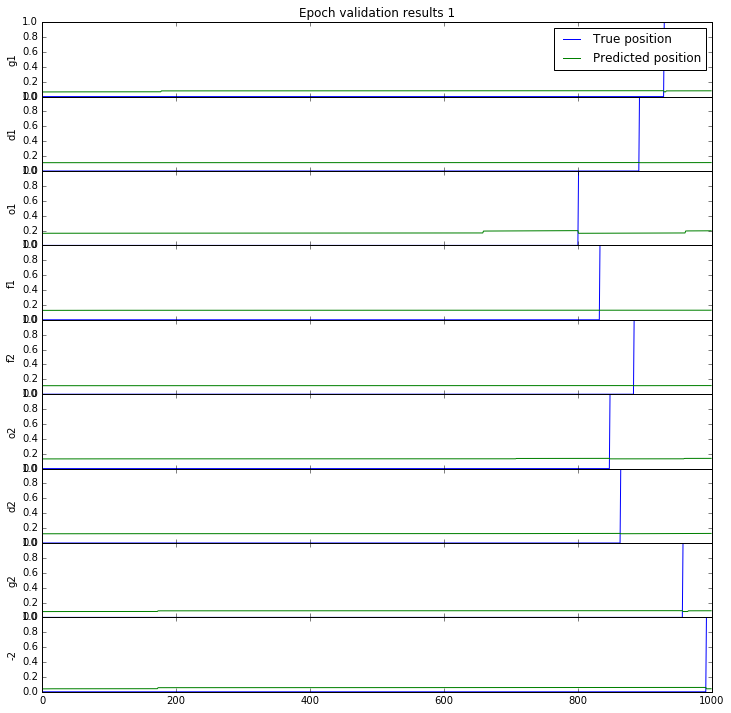

Wrote model to .\Models\weights_1.hdf
Epoch 2/2
753/752 [==============================] - 233s - loss: 2.1068 - categorical_accuracy: 0.1719 - val_loss: 2.0516 - val_categorical_accuracy: 0.2237
Wrote model to .\Models\weights_2.hdf
Epoch 3/3
753/752 [==============================] - 233s - loss: 2.1003 - categorical_accuracy: 0.1701 - val_loss: 2.0546 - val_categorical_accuracy: 0.2136
Wrote model to .\Models\weights_3.hdf
Epoch 4/4
753/752 [==============================] - 233s - loss: 2.0819 - categorical_accuracy: 0.1790 - val_loss: 2.0506 - val_categorical_accuracy: 0.2170
Wrote model to .\Models\weights_4.hdf
Epoch 5/5
753/752 [==============================] - 232s - loss: 2.0781 - categorical_accuracy: 0.1824 - val_loss: 2.0310 - val_categorical_accuracy: 0.2160
Wrote model to .\Models\weights_5.hdf
Epoch 6/6
753/752 [==============================] - 233s - loss: 2.0759 - categorical_accuracy: 0.1830 - val_loss: 2.0387 - val_categorical_accuracy: 0.2144
Wrote model to .\Mod

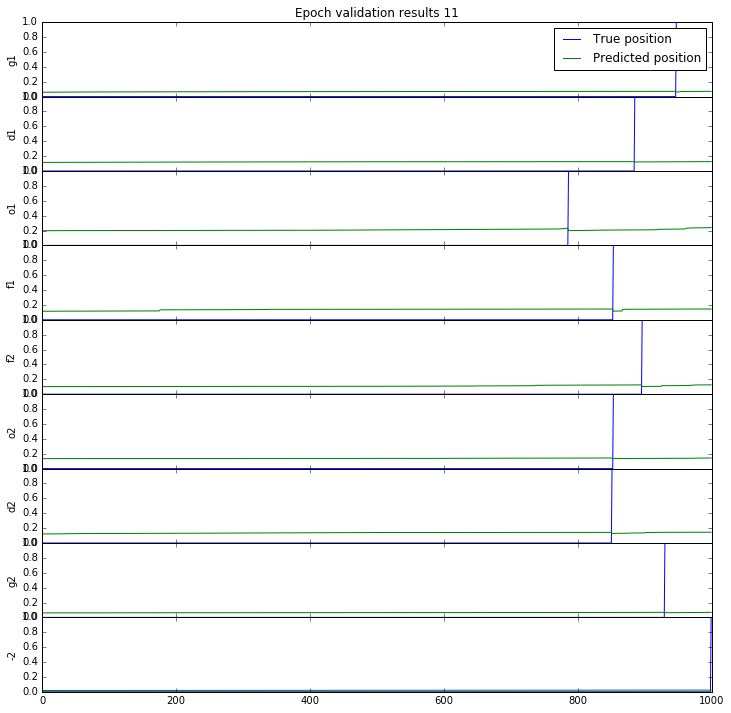

Wrote model to .\Models\weights_11.hdf
Epoch 12/12
753/752 [==============================] - 232s - loss: 2.0533 - categorical_accuracy: 0.1945 - val_loss: 1.9957 - val_categorical_accuracy: 0.2186
Wrote model to .\Models\weights_12.hdf
Epoch 13/13
753/752 [==============================] - 232s - loss: 2.0384 - categorical_accuracy: 0.1981 - val_loss: 1.9789 - val_categorical_accuracy: 0.2138
Wrote model to .\Models\weights_13.hdf
Epoch 14/14
753/752 [==============================] - 233s - loss: 2.0256 - categorical_accuracy: 0.2054 - val_loss: 1.9369 - val_categorical_accuracy: 0.2152
Wrote model to .\Models\weights_14.hdf
Epoch 15/15
753/752 [==============================] - 235s - loss: 2.0150 - categorical_accuracy: 0.2165 - val_loss: 1.8635 - val_categorical_accuracy: 0.3484
Wrote model to .\Models\weights_15.hdf
Epoch 16/16
753/752 [==============================] - 233s - loss: 1.9872 - categorical_accuracy: 0.2343 - val_loss: 1.7660 - val_categorical_accuracy: 0.4532
Wrote

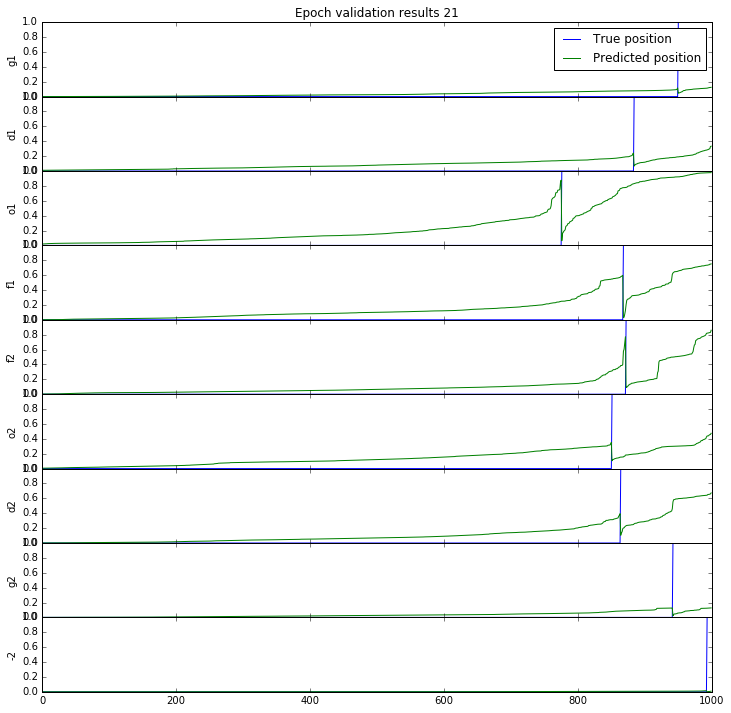

Wrote model to .\Models\weights_21.hdf
Epoch 22/22
753/752 [==============================] - 234s - loss: 1.7749 - categorical_accuracy: 0.3312 - val_loss: 1.1057 - val_categorical_accuracy: 0.6428
Wrote model to .\Models\weights_22.hdf
Epoch 23/23
753/752 [==============================] - 231s - loss: 1.7381 - categorical_accuracy: 0.3475 - val_loss: 1.0369 - val_categorical_accuracy: 0.6822
Wrote model to .\Models\weights_23.hdf
Epoch 24/24
753/752 [==============================] - 231s - loss: 1.7032 - categorical_accuracy: 0.3640 - val_loss: 0.9695 - val_categorical_accuracy: 0.6947
Wrote model to .\Models\weights_24.hdf
Epoch 25/25
753/752 [==============================] - 231s - loss: 1.6735 - categorical_accuracy: 0.3752 - val_loss: 0.9104 - val_categorical_accuracy: 0.7412
Wrote model to .\Models\weights_25.hdf
Epoch 26/26
753/752 [==============================] - 233s - loss: 1.6482 - categorical_accuracy: 0.3844 - val_loss: 0.8395 - val_categorical_accuracy: 0.7487
Wrote

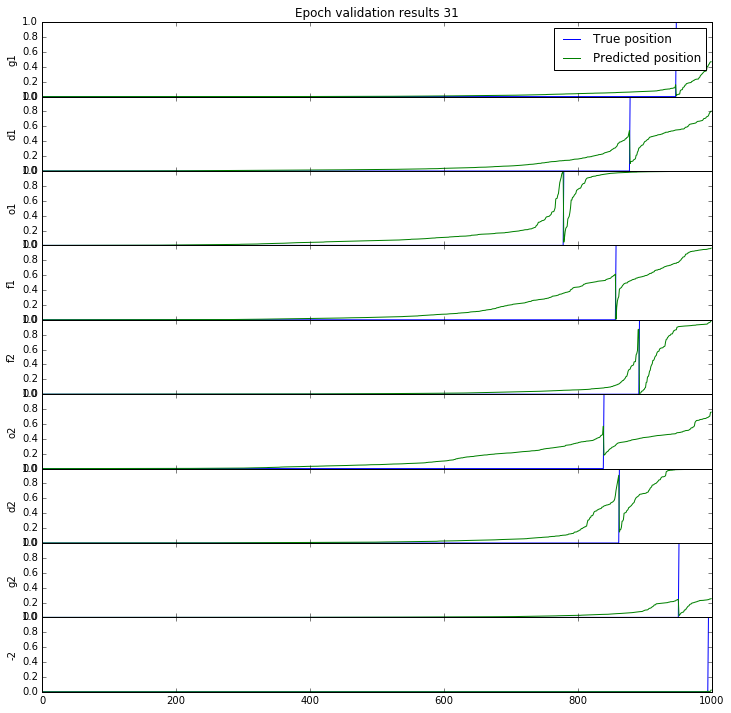

Wrote model to .\Models\weights_31.hdf
Epoch 32/32
753/752 [==============================] - 233s - loss: 1.5115 - categorical_accuracy: 0.4412 - val_loss: 0.6078 - val_categorical_accuracy: 0.8173
Wrote model to .\Models\weights_32.hdf
Epoch 33/33
753/752 [==============================] - 232s - loss: 1.4952 - categorical_accuracy: 0.4489 - val_loss: 0.5736 - val_categorical_accuracy: 0.8460
Wrote model to .\Models\weights_33.hdf
Epoch 34/34
753/752 [==============================] - 231s - loss: 1.4557 - categorical_accuracy: 0.4663 - val_loss: 0.5561 - val_categorical_accuracy: 0.8593
Wrote model to .\Models\weights_34.hdf
Epoch 35/35
753/752 [==============================] - 231s - loss: 1.4291 - categorical_accuracy: 0.4775 - val_loss: 0.5449 - val_categorical_accuracy: 0.8465
Wrote model to .\Models\weights_35.hdf
Epoch 36/36
753/752 [==============================] - 233s - loss: 1.4148 - categorical_accuracy: 0.4826 - val_loss: 0.5294 - val_categorical_accuracy: 0.8569
Wrote

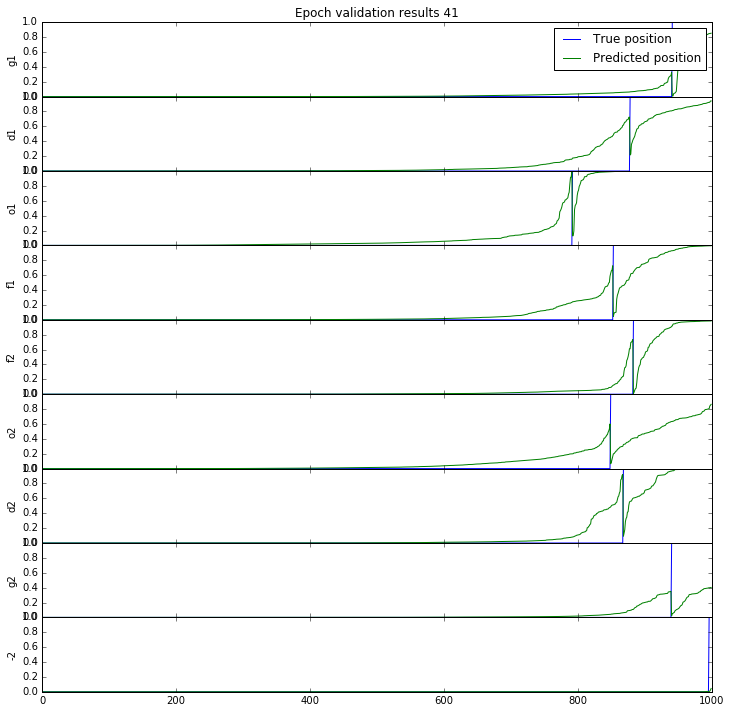

Wrote model to .\Models\weights_41.hdf
Epoch 42/42
753/752 [==============================] - 232s - loss: 1.2908 - categorical_accuracy: 0.5305 - val_loss: 0.4383 - val_categorical_accuracy: 0.8715
Wrote model to .\Models\weights_42.hdf
Epoch 43/43
753/752 [==============================] - 231s - loss: 1.2782 - categorical_accuracy: 0.5337 - val_loss: 0.3757 - val_categorical_accuracy: 0.8878
Wrote model to .\Models\weights_43.hdf
Epoch 44/44
753/752 [==============================] - 232s - loss: 1.2691 - categorical_accuracy: 0.5376 - val_loss: 0.3781 - val_categorical_accuracy: 0.8910
Wrote model to .\Models\weights_44.hdf
Epoch 45/45
753/752 [==============================] - 233s - loss: 1.2337 - categorical_accuracy: 0.5481 - val_loss: 0.3654 - val_categorical_accuracy: 0.8891
Wrote model to .\Models\weights_45.hdf
Epoch 46/46
753/752 [==============================] - 233s - loss: 1.2272 - categorical_accuracy: 0.5524 - val_loss: 0.3447 - val_categorical_accuracy: 0.8870
Wrote

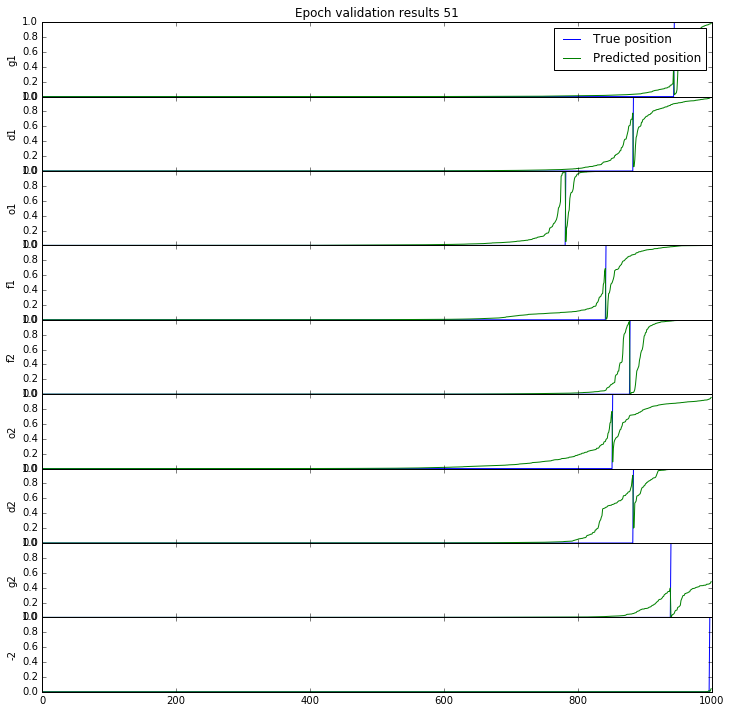

Wrote model to .\Models\weights_51.hdf
Epoch 52/52
753/752 [==============================] - 232s - loss: 1.1327 - categorical_accuracy: 0.5965 - val_loss: 0.3079 - val_categorical_accuracy: 0.9242
Wrote model to .\Models\weights_52.hdf
Epoch 53/53
753/752 [==============================] - 233s - loss: 1.1147 - categorical_accuracy: 0.6002 - val_loss: 0.2915 - val_categorical_accuracy: 0.9162
Transform of type 'VideoLoaderRandom' returned None.
Wrote model to .\Models\weights_53.hdf
Epoch 54/54
753/752 [==============================] - 234s - loss: 1.1156 - categorical_accuracy: 0.6001 - val_loss: 0.2751 - val_categorical_accuracy: 0.9168
Wrote model to .\Models\weights_54.hdf
Epoch 55/55
753/752 [==============================] - 231s - loss: 1.0773 - categorical_accuracy: 0.6133 - val_loss: 0.2697 - val_categorical_accuracy: 0.9074
Wrote model to .\Models\weights_55.hdf
Epoch 56/56
753/752 [==============================] - 231s - loss: 1.0495 - categorical_accuracy: 0.6218 - val_

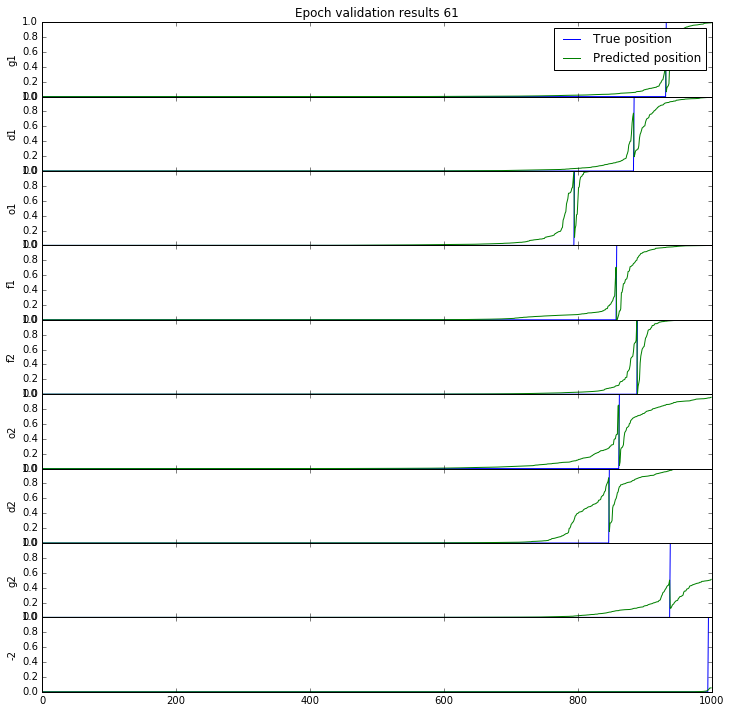

Wrote model to .\Models\weights_61.hdf
Epoch 62/62
753/752 [==============================] - 232s - loss: 0.9881 - categorical_accuracy: 0.6443 - val_loss: 0.2270 - val_categorical_accuracy: 0.9309
Wrote model to .\Models\weights_62.hdf
Epoch 63/63
753/752 [==============================] - 232s - loss: 0.9817 - categorical_accuracy: 0.6536 - val_loss: 0.2209 - val_categorical_accuracy: 0.9303
Wrote model to .\Models\weights_63.hdf
Epoch 64/64
753/752 [==============================] - 232s - loss: 0.9702 - categorical_accuracy: 0.6533 - val_loss: 0.2070 - val_categorical_accuracy: 0.9391
Wrote model to .\Models\weights_64.hdf
Epoch 65/65
753/752 [==============================] - 234s - loss: 0.9491 - categorical_accuracy: 0.6621 - val_loss: 0.2120 - val_categorical_accuracy: 0.9362
Wrote model to .\Models\weights_65.hdf
Epoch 66/66
753/752 [==============================] - 233s - loss: 0.9492 - categorical_accuracy: 0.6605 - val_loss: 0.2050 - val_categorical_accuracy: 0.9319
Wrote

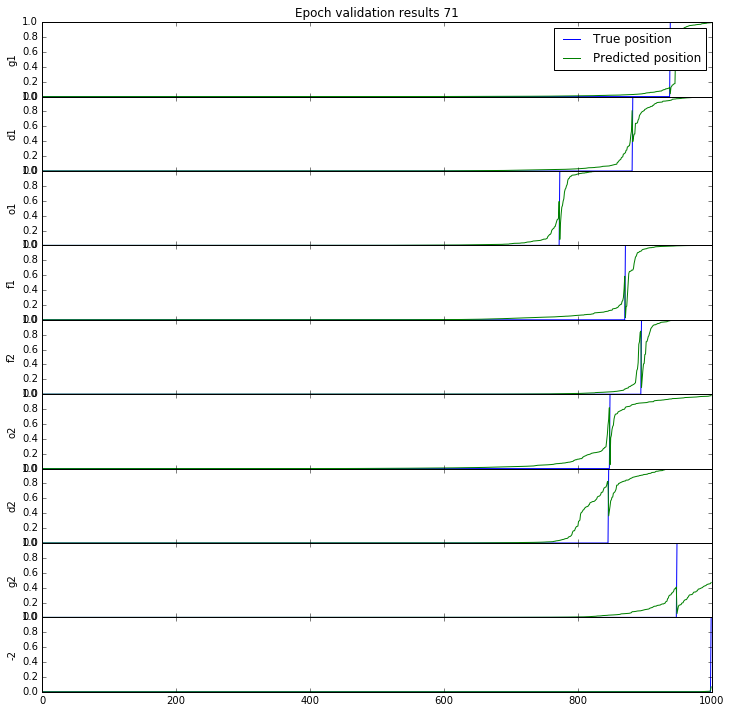

Wrote model to .\Models\weights_71.hdf
Epoch 72/72
753/752 [==============================] - 234s - loss: 0.8727 - categorical_accuracy: 0.6887 - val_loss: 0.1930 - val_categorical_accuracy: 0.9348
Wrote model to .\Models\weights_72.hdf
Epoch 73/73
753/752 [==============================] - 233s - loss: 0.8584 - categorical_accuracy: 0.6969 - val_loss: 0.1915 - val_categorical_accuracy: 0.9303
Wrote model to .\Models\weights_73.hdf
Epoch 74/74
753/752 [==============================] - 232s - loss: 0.8665 - categorical_accuracy: 0.6934 - val_loss: 0.1921 - val_categorical_accuracy: 0.9388
Wrote model to .\Models\weights_74.hdf
Epoch 75/75
753/752 [==============================] - 233s - loss: 0.8712 - categorical_accuracy: 0.6911 - val_loss: 0.1824 - val_categorical_accuracy: 0.9372
Wrote model to .\Models\weights_75.hdf
Epoch 76/76
753/752 [==============================] - 233s - loss: 0.8521 - categorical_accuracy: 0.7001 - val_loss: 0.1908 - val_categorical_accuracy: 0.9479
Wrote

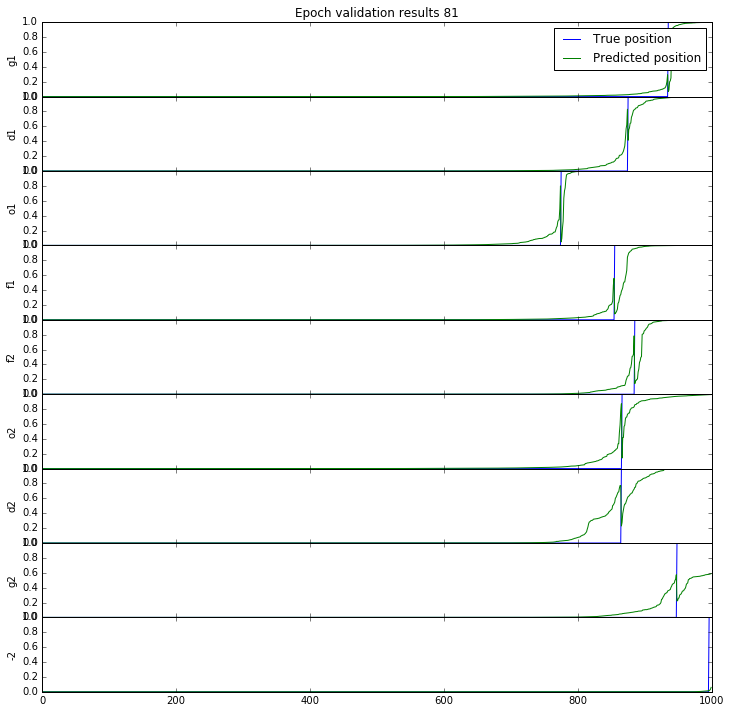

Wrote model to .\Models\weights_81.hdf
Epoch 82/82
753/752 [==============================] - 233s - loss: 0.7911 - categorical_accuracy: 0.7227 - val_loss: 0.1665 - val_categorical_accuracy: 0.9527
Wrote model to .\Models\weights_82.hdf
Epoch 83/83
753/752 [==============================] - 231s - loss: 0.7847 - categorical_accuracy: 0.7270 - val_loss: 0.1504 - val_categorical_accuracy: 0.9535
Wrote model to .\Models\weights_83.hdf
Epoch 84/84
753/752 [==============================] - 233s - loss: 0.7917 - categorical_accuracy: 0.7250 - val_loss: 0.1705 - val_categorical_accuracy: 0.9487
Wrote model to .\Models\weights_84.hdf
Epoch 85/85
753/752 [==============================] - 233s - loss: 0.8003 - categorical_accuracy: 0.7210 - val_loss: 0.1591 - val_categorical_accuracy: 0.9561
Wrote model to .\Models\weights_85.hdf
Epoch 86/86
753/752 [==============================] - 233s - loss: 0.7755 - categorical_accuracy: 0.7337 - val_loss: 0.1487 - val_categorical_accuracy: 0.9519
Wrote

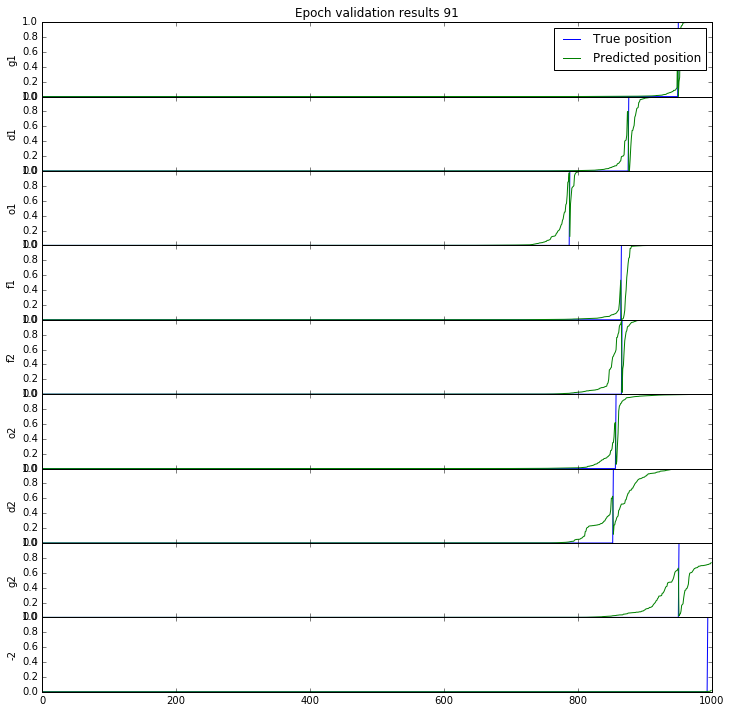

Wrote model to .\Models\weights_91.hdf
Epoch 92/92
753/752 [==============================] - 234s - loss: 0.7263 - categorical_accuracy: 0.7465 - val_loss: 0.1279 - val_categorical_accuracy: 0.9569
Wrote model to .\Models\weights_92.hdf
Epoch 93/93
753/752 [==============================] - 233s - loss: 0.7180 - categorical_accuracy: 0.7521 - val_loss: 0.1555 - val_categorical_accuracy: 0.9551
Wrote model to .\Models\weights_93.hdf
Epoch 94/94
753/752 [==============================] - 233s - loss: 0.7188 - categorical_accuracy: 0.7542 - val_loss: 0.1552 - val_categorical_accuracy: 0.9449
Wrote model to .\Models\weights_94.hdf
Epoch 95/95
753/752 [==============================] - 233s - loss: 0.7033 - categorical_accuracy: 0.7550 - val_loss: 0.1436 - val_categorical_accuracy: 0.9455
Wrote model to .\Models\weights_95.hdf
Epoch 96/96
753/752 [==============================] - 231s - loss: 0.6912 - categorical_accuracy: 0.7654 - val_loss: 0.1476 - val_categorical_accuracy: 0.9495
Wrote

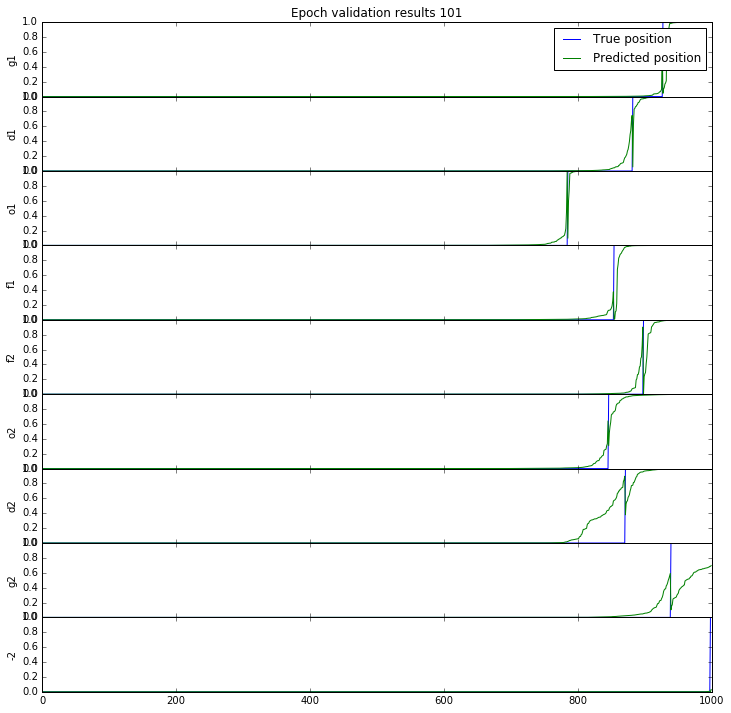

Wrote model to .\Models\weights_101.hdf
Epoch 102/102
753/752 [==============================] - 232s - loss: 0.6649 - categorical_accuracy: 0.7753 - val_loss: 0.1392 - val_categorical_accuracy: 0.9580
Wrote model to .\Models\weights_102.hdf
Epoch 103/103
753/752 [==============================] - 232s - loss: 0.6704 - categorical_accuracy: 0.7748 - val_loss: 0.1298 - val_categorical_accuracy: 0.9574
Wrote model to .\Models\weights_103.hdf
Epoch 104/104
753/752 [==============================] - 232s - loss: 0.6419 - categorical_accuracy: 0.7798 - val_loss: 0.1410 - val_categorical_accuracy: 0.9574
Wrote model to .\Models\weights_104.hdf
Epoch 105/105
753/752 [==============================] - 232s - loss: 0.6462 - categorical_accuracy: 0.7795 - val_loss: 0.1335 - val_categorical_accuracy: 0.9585
Wrote model to .\Models\weights_105.hdf
Epoch 106/106
753/752 [==============================] - 234s - loss: 0.6436 - categorical_accuracy: 0.7837 - val_loss: 0.1233 - val_categorical_accurac

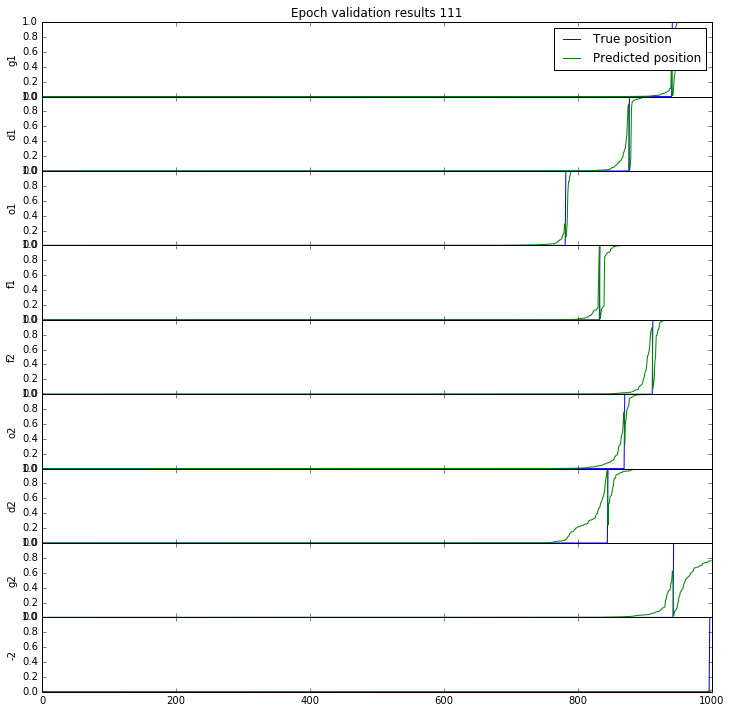

Wrote model to .\Models\weights_111.hdf
Epoch 112/112
753/752 [==============================] - 232s - loss: 0.6177 - categorical_accuracy: 0.7912 - val_loss: 0.1160 - val_categorical_accuracy: 0.9556
Wrote model to .\Models\weights_112.hdf
Epoch 113/113
753/752 [==============================] - 232s - loss: 0.6084 - categorical_accuracy: 0.7950 - val_loss: 0.1303 - val_categorical_accuracy: 0.9553
Wrote model to .\Models\weights_113.hdf
Epoch 114/114
753/752 [==============================] - 231s - loss: 0.6053 - categorical_accuracy: 0.7971 - val_loss: 0.1441 - val_categorical_accuracy: 0.9569
Wrote model to .\Models\weights_114.hdf
Epoch 115/115
753/752 [==============================] - 232s - loss: 0.5935 - categorical_accuracy: 0.8014 - val_loss: 0.1192 - val_categorical_accuracy: 0.9638
Wrote model to .\Models\weights_115.hdf
Epoch 116/116
753/752 [==============================] - 232s - loss: 0.6010 - categorical_accuracy: 0.7972 - val_loss: 0.1144 - val_categorical_accurac

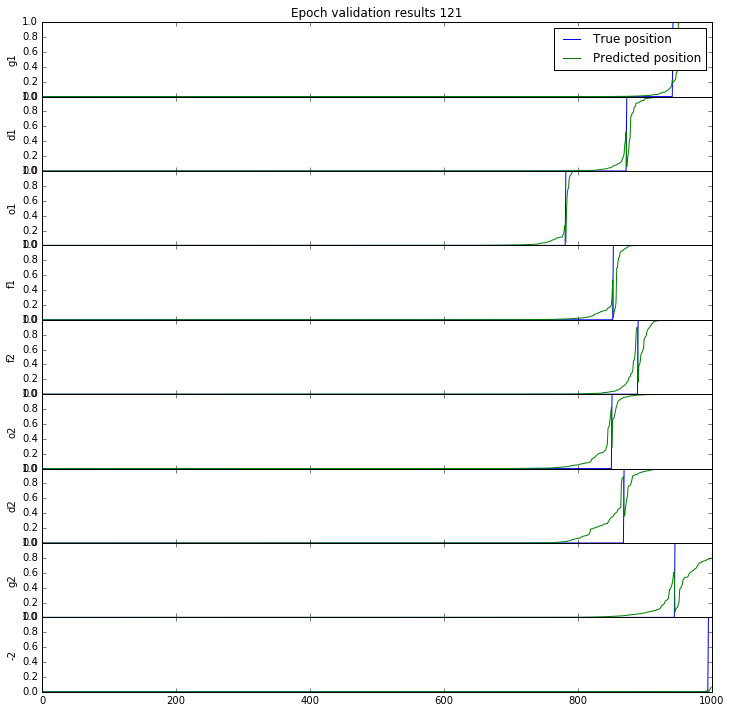

Wrote model to .\Models\weights_121.hdf
Epoch 122/122
753/752 [==============================] - 232s - loss: 0.5580 - categorical_accuracy: 0.8131 - val_loss: 0.1087 - val_categorical_accuracy: 0.9646
Wrote model to .\Models\weights_122.hdf
Epoch 123/123
753/752 [==============================] - 234s - loss: 0.5703 - categorical_accuracy: 0.8116 - val_loss: 0.1048 - val_categorical_accuracy: 0.9633
Wrote model to .\Models\weights_123.hdf
Epoch 124/124
753/752 [==============================] - 287s - loss: 0.5609 - categorical_accuracy: 0.8131 - val_loss: 0.1228 - val_categorical_accuracy: 0.9665
Wrote model to .\Models\weights_124.hdf
Epoch 125/125
753/752 [==============================] - 345s - loss: 0.5679 - categorical_accuracy: 0.8119 - val_loss: 0.1166 - val_categorical_accuracy: 0.9628
Wrote model to .\Models\weights_125.hdf
Epoch 126/126
753/752 [==============================] - 346s - loss: 0.5572 - categorical_accuracy: 0.8129 - val_loss: 0.0922 - val_categorical_accurac

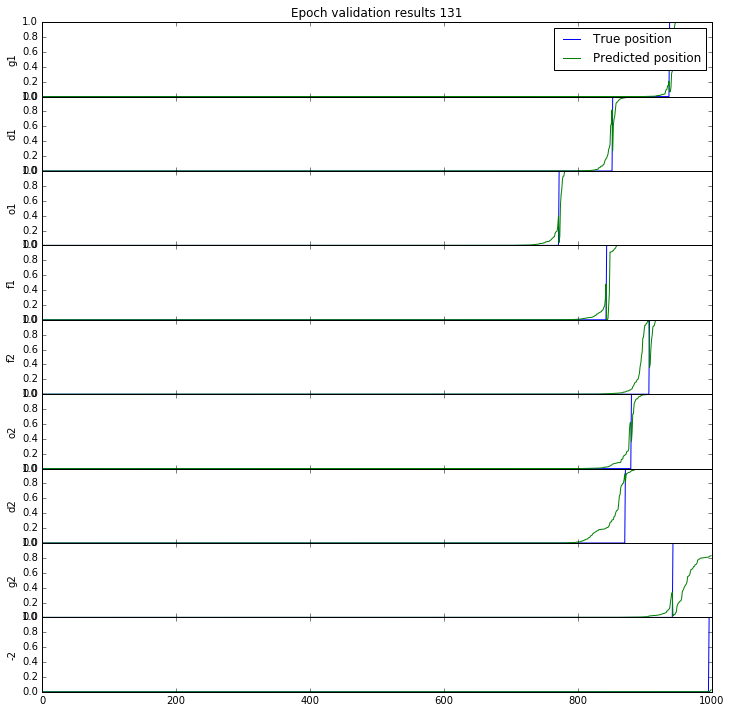

Wrote model to .\Models\weights_131.hdf
Epoch 132/132
753/752 [==============================] - 343s - loss: 0.5257 - categorical_accuracy: 0.8233 - val_loss: 0.1197 - val_categorical_accuracy: 0.9553
Wrote model to .\Models\weights_132.hdf
Epoch 133/133
752/752 [============================>.] - ETA: 0s - loss: 0.5387 - categorical_accuracy: 0.8244Transform of type 'VideoLoaderRandom' returned None.
Transform of type 'VideoLoaderRandom' returned None.
753/752 [==============================] - 247s - loss: 0.5387 - categorical_accuracy: 0.8243 - val_loss: 0.1020 - val_categorical_accuracy: 0.9668
Wrote model to .\Models\weights_133.hdf
Epoch 134/134
141/752 [====>.........................] - ETA: 180s - loss: 0.5555 - categorical_accuracy: 0.8138

KeyboardInterrupt: 

In [8]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 20
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)



Batch size 20: 752 training batches, 188 validation batches
Epoch 136/136
753/752 [==============================] - 386s - loss: 0.4998 - categorical_accuracy: 0.8400 - val_loss: 0.0943 - val_categorical_accuracy: 0.9710


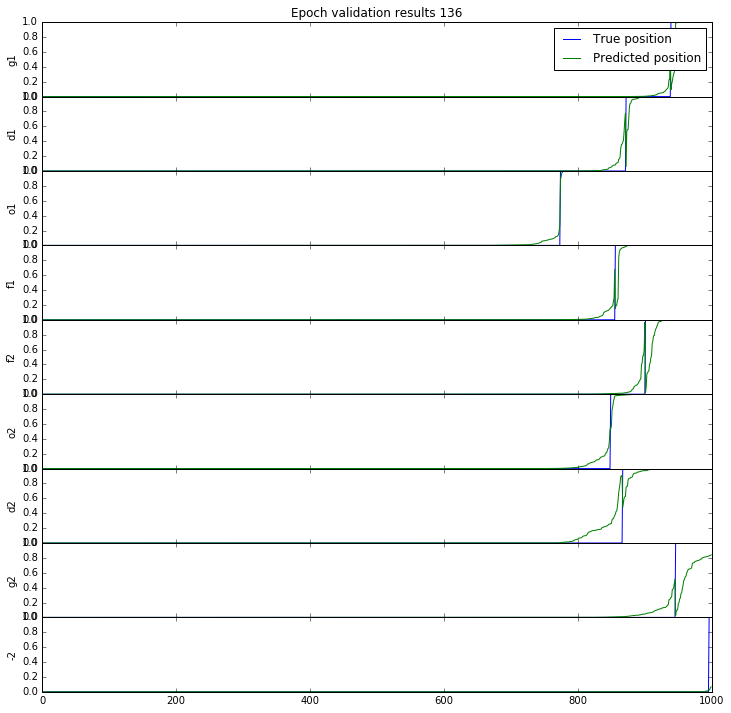

Wrote model to .\Models\weights_136.hdf
Epoch 137/137
753/752 [==============================] - 384s - loss: 0.4819 - categorical_accuracy: 0.8397 - val_loss: 0.0879 - val_categorical_accuracy: 0.9753
Wrote model to .\Models\weights_137.hdf
Epoch 138/138
753/752 [==============================] - 387s - loss: 0.4744 - categorical_accuracy: 0.8400 - val_loss: 0.0808 - val_categorical_accuracy: 0.9758
Wrote model to .\Models\weights_138.hdf
Epoch 139/139
753/752 [==============================] - 885s - loss: 0.4871 - categorical_accuracy: 0.8414 - val_loss: 0.0871 - val_categorical_accuracy: 0.9734
Wrote model to .\Models\weights_139.hdf
Epoch 140/140
753/752 [==============================] - 891s - loss: 0.4701 - categorical_accuracy: 0.8439 - val_loss: 0.0913 - val_categorical_accuracy: 0.9731
Wrote model to .\Models\weights_140.hdf
Epoch 141/141
753/752 [==============================] - 879s - loss: 0.4814 - categorical_accuracy: 0.8404 - val_loss: 0.0811 - val_categorical_accurac

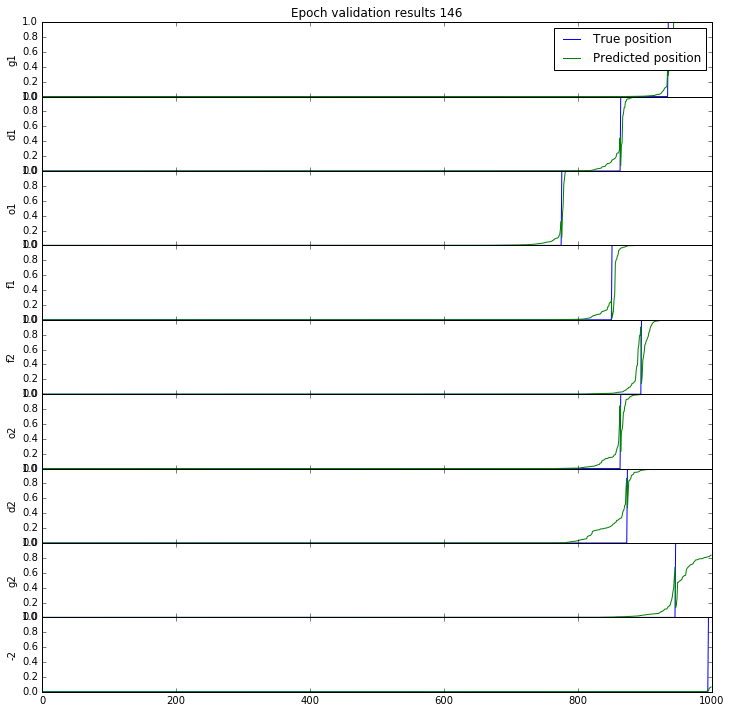

Wrote model to .\Models\weights_146.hdf
Epoch 147/147
753/752 [==============================] - 904s - loss: 0.4748 - categorical_accuracy: 0.8431 - val_loss: 0.0846 - val_categorical_accuracy: 0.9771
Wrote model to .\Models\weights_147.hdf
Epoch 148/148
753/752 [==============================] - 888s - loss: 0.4654 - categorical_accuracy: 0.8479 - val_loss: 0.0877 - val_categorical_accuracy: 0.9737
Wrote model to .\Models\weights_148.hdf
Epoch 149/149
753/752 [==============================] - 871s - loss: 0.4641 - categorical_accuracy: 0.8476 - val_loss: 0.0885 - val_categorical_accuracy: 0.9737
Wrote model to .\Models\weights_149.hdf
Epoch 150/150
753/752 [==============================] - 880s - loss: 0.4630 - categorical_accuracy: 0.8477 - val_loss: 0.0840 - val_categorical_accuracy: 0.9779
Wrote model to .\Models\weights_150.hdf
Epoch 151/151
753/752 [==============================] - 884s - loss: 0.4635 - categorical_accuracy: 0.8467 - val_loss: 0.0734 - val_categorical_accurac

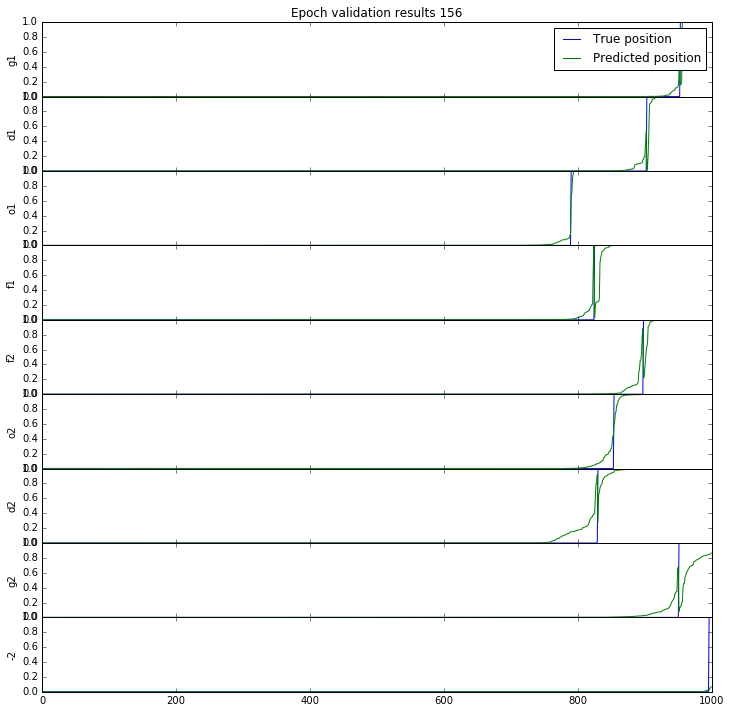

Wrote model to .\Models\weights_156.hdf
Epoch 157/157
753/752 [==============================] - 900s - loss: 0.4593 - categorical_accuracy: 0.8459 - val_loss: 0.0768 - val_categorical_accuracy: 0.9785
Wrote model to .\Models\weights_157.hdf
Epoch 158/158
753/752 [==============================] - 890s - loss: 0.4593 - categorical_accuracy: 0.8482 - val_loss: 0.0855 - val_categorical_accuracy: 0.9739
Wrote model to .\Models\weights_158.hdf
Epoch 159/159
753/752 [==============================] - 889s - loss: 0.4795 - categorical_accuracy: 0.8434 - val_loss: 0.0915 - val_categorical_accuracy: 0.9710
Wrote model to .\Models\weights_159.hdf
Epoch 160/160
753/752 [==============================] - 885s - loss: 0.4630 - categorical_accuracy: 0.8437 - val_loss: 0.0811 - val_categorical_accuracy: 0.9763
Wrote model to .\Models\weights_160.hdf
Epoch 161/161
753/752 [==============================] - 888s - loss: 0.4601 - categorical_accuracy: 0.8455 - val_loss: 0.0798 - val_categorical_accurac

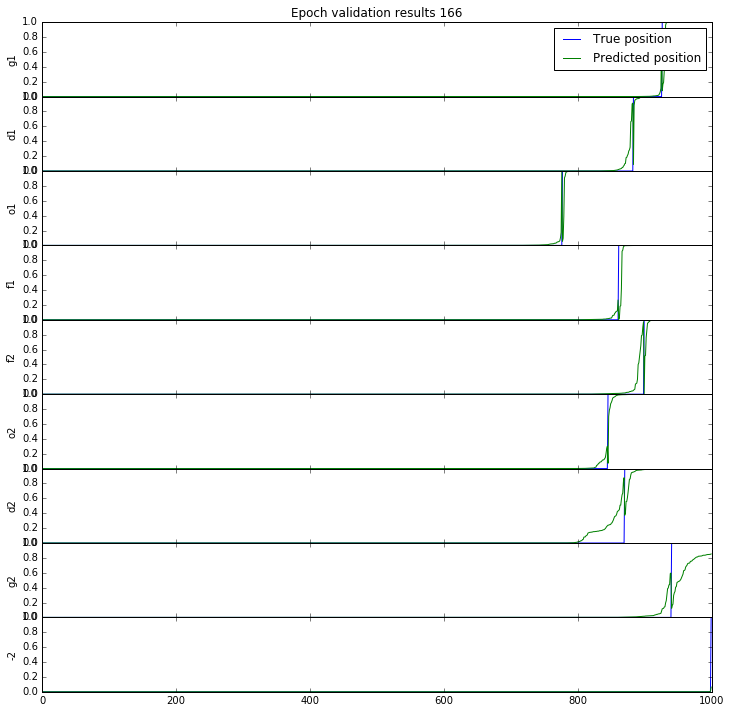

Wrote model to .\Models\weights_166.hdf
Epoch 167/167
753/752 [==============================] - 902s - loss: 0.4611 - categorical_accuracy: 0.8471 - val_loss: 0.0748 - val_categorical_accuracy: 0.9790
Wrote model to .\Models\weights_167.hdf
Epoch 168/168
753/752 [==============================] - 882s - loss: 0.4664 - categorical_accuracy: 0.8475 - val_loss: 0.0808 - val_categorical_accuracy: 0.9766
Wrote model to .\Models\weights_168.hdf
Epoch 169/169
753/752 [==============================] - 882s - loss: 0.4552 - categorical_accuracy: 0.8488 - val_loss: 0.0861 - val_categorical_accuracy: 0.9747
Wrote model to .\Models\weights_169.hdf
Epoch 170/170
753/752 [==============================] - 893s - loss: 0.4597 - categorical_accuracy: 0.8469 - val_loss: 0.0719 - val_categorical_accuracy: 0.9809
Wrote model to .\Models\weights_170.hdf
Epoch 171/171
753/752 [==============================] - 886s - loss: 0.4429 - categorical_accuracy: 0.8491 - val_loss: 0.0818 - val_categorical_accurac

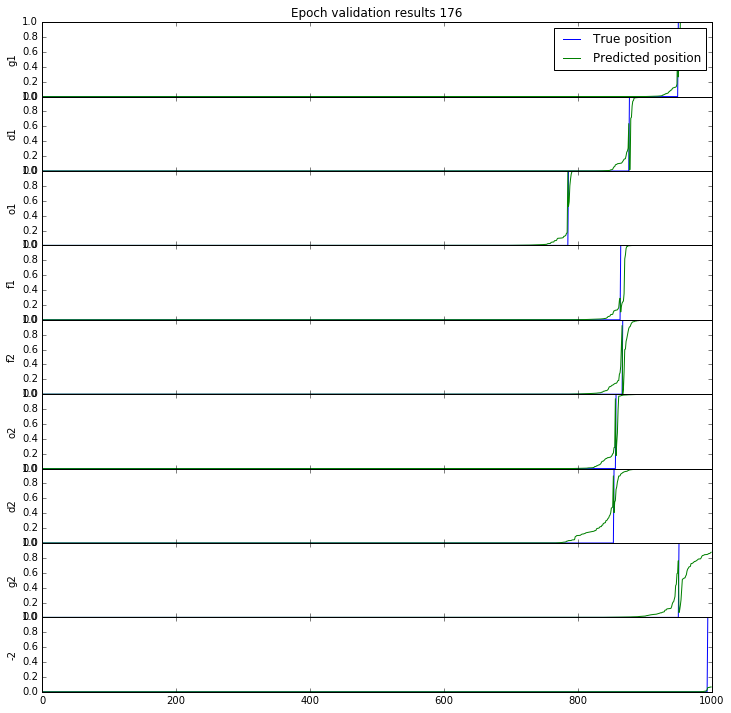

Wrote model to .\Models\weights_176.hdf
Epoch 177/177
753/752 [==============================] - 854s - loss: 0.4569 - categorical_accuracy: 0.8480 - val_loss: 0.0700 - val_categorical_accuracy: 0.9814
Wrote model to .\Models\weights_177.hdf
Epoch 178/178
753/752 [==============================] - 871s - loss: 0.4658 - categorical_accuracy: 0.8493 - val_loss: 0.0741 - val_categorical_accuracy: 0.9766
Wrote model to .\Models\weights_178.hdf
Epoch 179/179
753/752 [==============================] - 864s - loss: 0.4372 - categorical_accuracy: 0.8539 - val_loss: 0.0815 - val_categorical_accuracy: 0.9755
Wrote model to .\Models\weights_179.hdf
Epoch 180/180
753/752 [==============================] - 868s - loss: 0.4492 - categorical_accuracy: 0.8535 - val_loss: 0.0746 - val_categorical_accuracy: 0.9793
Wrote model to .\Models\weights_180.hdf
Epoch 181/181
753/752 [==============================] - 883s - loss: 0.4564 - categorical_accuracy: 0.8492 - val_loss: 0.0812 - val_categorical_accurac

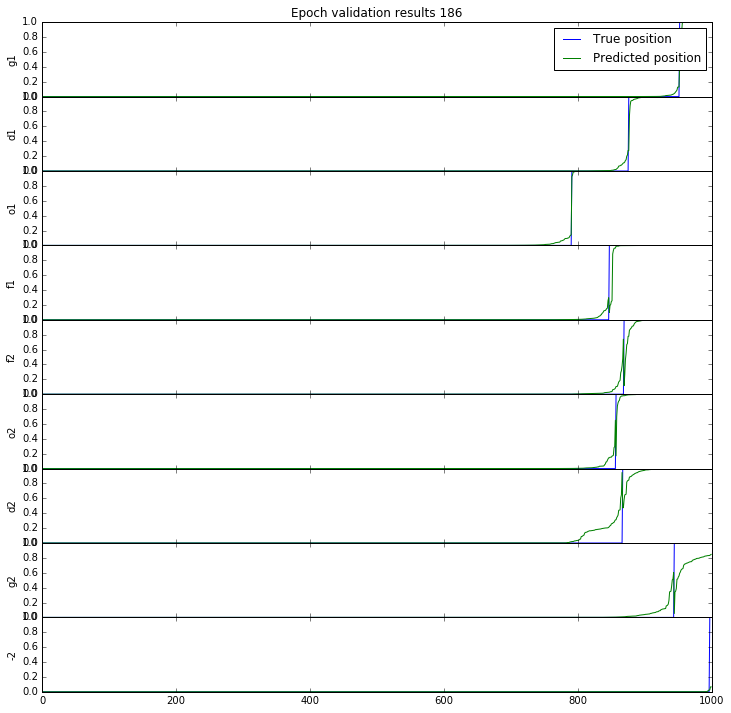

Wrote model to .\Models\weights_186.hdf
Epoch 187/187
503/752 [===================>..........] - ETA: 288s - loss: 0.4502 - categorical_accuracy: 0.8492

KeyboardInterrupt: 

In [9]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 135
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 20
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
